In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv1D, Flatten
import tensorflow as tf
import joblib
import shap
import matplotlib.pyplot as plt
import librosa.display

2024-07-19 15:30:49.451886: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 15:30:49.496567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 15:30:49.496589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 15:30:49.497782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 15:30:49.505522: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 15:30:49.506914: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Sabit özellik boyutu için parametreler
n_mfcc = 13
max_pad_len = 216

# Ses dosyalarının bulunduğu klasörün yolu --> Ana veri seti klasörü olacak
audio_folder = 'tess_crema'

# Fonksiyon: Dosya adından duygu bilgisini çıkarma
def get_label_from_filename(file):
    filename = os.path.basename(file)  # Dosya adını al
    emotion = filename.split('_')[2]   # Dosya adından duygu kısmını al
    return emotion

# Fonksiyon: Sabit boyutlu MFCC, RMSE ve ZCR özelliklerini çıkarma
def extract_features(file_path, n_mfcc=13, max_pad_len=216):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    rmse = librosa.feature.rms(y=y)
    zcr = librosa.feature.zero_crossing_rate(y)

    # Özellikleri birleştirme ve sabit boyut ayarlama
    features = np.concatenate((mfcc, rmse, zcr), axis=0)
    if features.shape[1] < max_pad_len:
        pad_width = max_pad_len - features.shape[1]
        features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        features = features[:, :max_pad_len]
    return features

# Veri seti için boş listeler oluşturma
features = []
labels = []

# Ses dosyalarını işleme
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_folder, filename)
        
        # Sabit boyutlu özellikleri çıkarma
        extracted_features = extract_features(file_path, n_mfcc=n_mfcc, max_pad_len=max_pad_len)
        
        flattened_features = np.ravel(extracted_features)
        
        # Özellikleri listeye ekleme
        features.append(flattened_features)
        
        # Dosyanın duygu etiketini alarak labels listesine ekleme
        label = get_label_from_filename(file_path)
        labels.append(label)

# Verileri pandas DataFrame'e dönüştürme
df = pd.DataFrame(features)
df['labels'] = labels

# Verileri CSV dosyasına kaydetme
df.to_csv('audio_features.csv', index=False)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['labels'])

# Verileri ve etiketleri ayırma
x = df.drop(columns=['labels']).values
y = y_encoded

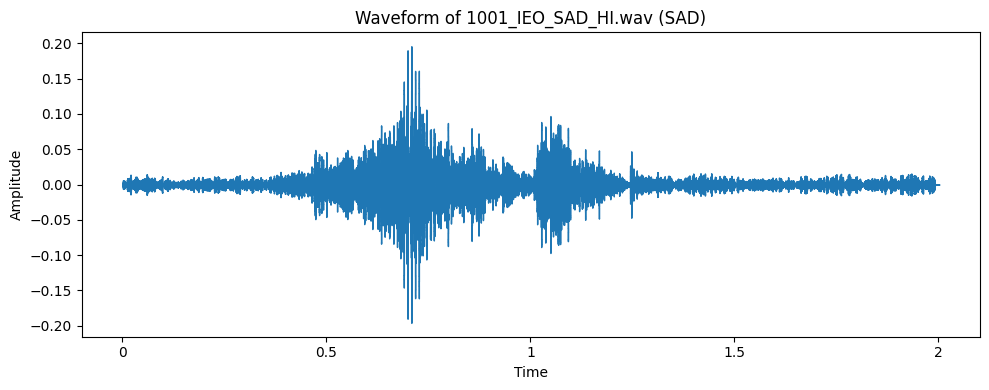

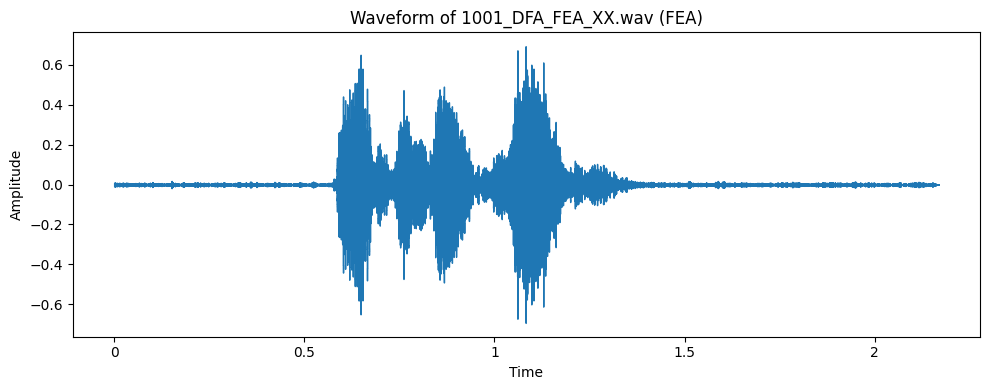

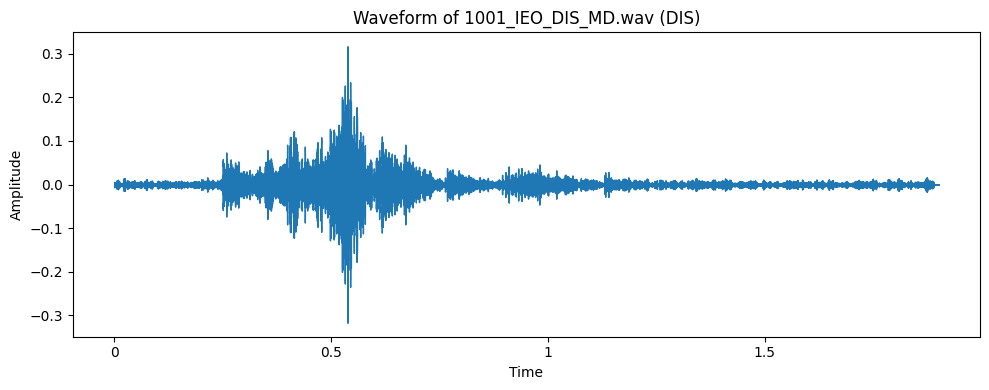

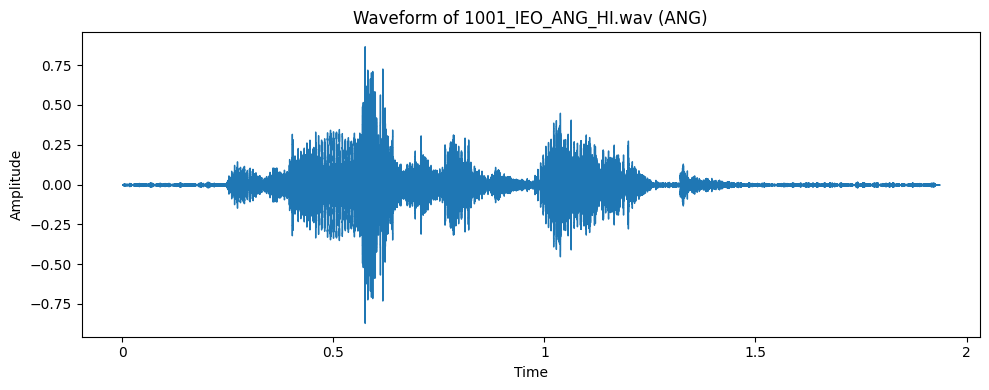

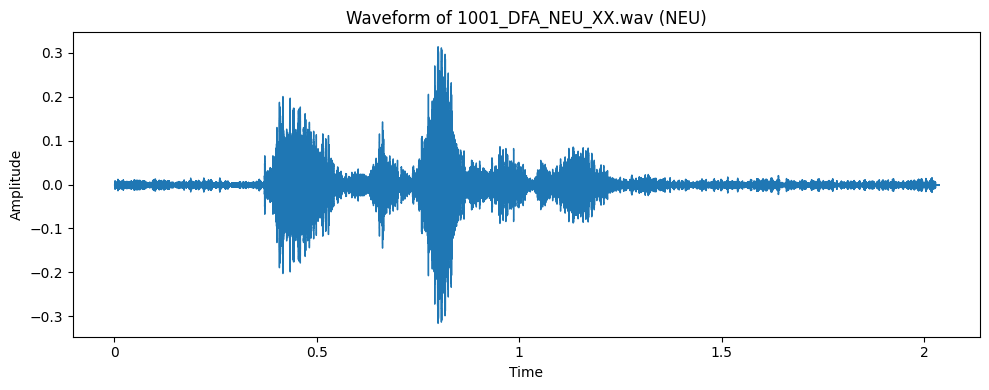

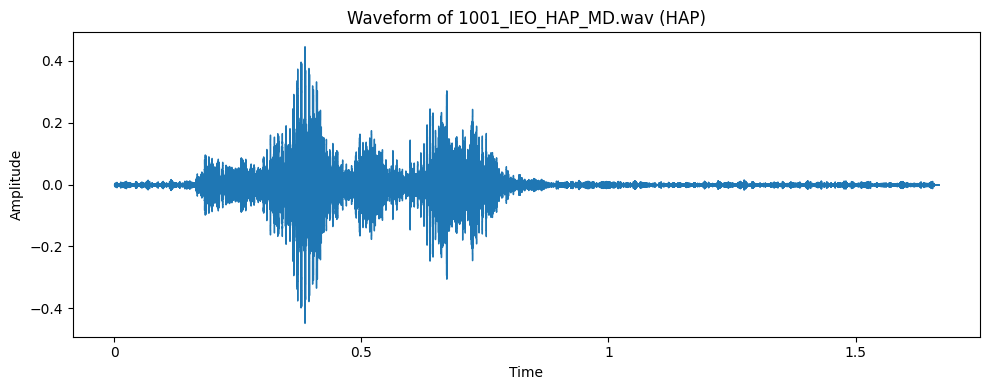

In [3]:
# Ses dosyalarının bulunduğu klasörün yolu
audio_samples = 'sample_audios'

# Duygular
emotions = ['SAD', 'FEA', 'DIS', 'ANG', 'NEU', 'HAP']

# Her duygu için örnek bir ses dosyası seçme
example_files = {emotion: None for emotion in emotions}

# Ses dosyalarını kontrol etme ve her duygudan bir örnek alma
for filename in os.listdir(audio_samples):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_samples, filename)
        emotion = filename.split('_')[2]  # Dosya adından duygu kısmını al
        if emotion in example_files and example_files[emotion] is None:
            example_files[emotion] = file_path

# Ses sinyallerini görselleştirme
def plot_audio_signal(audio_file, emotion):
    y, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform of {os.path.basename(audio_file)} ({emotion})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Her duygunun örnek ses sinyalini görselleştirme
for emotion, file_path in example_files.items():
    if file_path:
        plot_audio_signal(file_path, emotion)
    else:
        print(f'{emotion} için örnek ses dosyası bulunamadı.')

In [4]:
# Verileri eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Verileri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model oluşturma
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # 6 sınıf için softmax çıkış katmanı
])

# Modeli derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Modeli değerlendirme
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
197/197 [==============================] - 4s 17ms/step - loss: 1.3942 - accuracy: 0.5305 - val_loss: 1.1406 - val_accuracy: 0.5619
Epoch 2/50
197/197 [==============================] - 3s 15ms/step - loss: 0.9221 - accuracy: 0.6518 - val_loss: 1.0778 - val_accuracy: 0.5841
Epoch 3/50
197/197 [==============================] - 3s 16ms/step - loss: 0.7254 - accuracy: 0.7299 - val_loss: 1.1661 - val_accuracy: 0.5778
Epoch 4/50
197/197 [==============================] - 3s 16ms/step - loss: 0.5660 - accuracy: 0.7979 - val_loss: 1.1776 - val_accuracy: 0.6006
Epoch 5/50
197/197 [==============================] - 3s 16ms/step - loss: 0.4064 - accuracy: 0.8606 - val_loss: 1.3021 - val_accuracy: 0.5790
Epoch 6/50
197/197 [==============================] - 3s 16ms/step - loss: 0.3161 - accuracy: 0.8935 - val_loss: 1.4069 - val_accuracy: 0.5898
Epoch 7/50
197/197 [==============================] - 3s 16ms/step - loss: 0.2521 - accuracy: 0.9230 - val_loss: 1.7465 - val_accuracy: 0.5867

In [5]:
# Modeli kaydetme

# Modelin yapısı
model_json = model.to_json()
with open("emotion_recognition_model.json", "w") as json_file:
    json_file.write(model_json)

# Modelin ağırlıklarını kaydetme
model.save_weights("emotion_recognition_model_weights.h5")

# Scaler ve label encoder'ı kaydetme
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

1/1 [==============================] - 0s 111ms/step


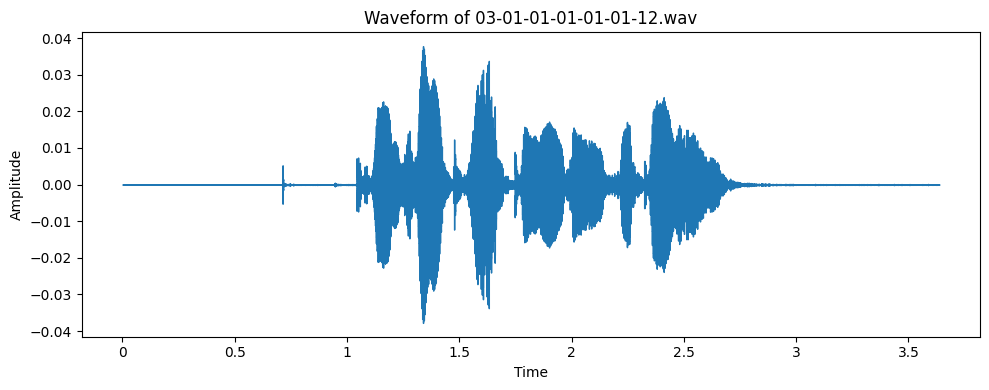

Predicted emotion: FEA


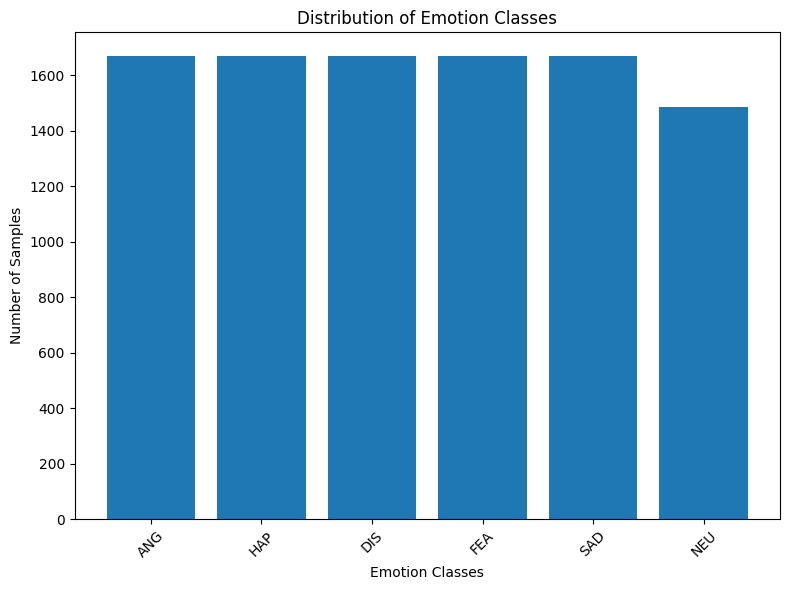

In [6]:
# Modeli yükleme ve tahmin yapma
def predict_emotion(audio_file):
    # Modeli yükleme
    with open('emotion_recognition_model.json', 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    model.load_weights('emotion_recognition_model_weights.h5')
    
    # Scaler ve label encoder'ı yükleme
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    # Sabit boyutlu özellikleri çıkarma
    extracted_features = extract_features(audio_file, n_mfcc=n_mfcc, max_pad_len=max_pad_len)
    
    flattened_features = np.ravel(extracted_features)
    
    # Özellikleri ölçeklendirme
    scaled_features = scaler.transform([flattened_features])
    
    # Tahmin yapma
    predictions = model.predict(scaled_features)
    predicted_label = np.argmax(predictions, axis=1)
    
    # Tahmin edilen etiketi orijinal etiketle eşleştirme
    emotion = label_encoder.inverse_transform(predicted_label)
    
    # Ses sinyalini görselleştir
    plot_audio_signal(audio_file)
    
    return emotion[0]

# Ses sinyalini görselleştirme fonksiyonu
def plot_audio_signal(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform of {os.path.basename(audio_file)}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Örnek bir ses dosyasını tahmin etme ve sinyalini görselleştirme
audio_file = '/home/songul/Desktop/97lik/archive/Actor_12/03-01-01-01-01-01-12.wav'  # Bu kısmı değiştirebilirsiniz
predicted_emotion = predict_emotion(audio_file)
print(f'Predicted emotion: {predicted_emotion}')


"""
## -----> SHAP EXPLAINER <-----

# SHAP için explainer oluşturun
explainer = shap.Explainer(model, X_train_scaled, max_evals=3537)

# SHAP değerlerini hesaplayın
shap_values = explainer(X_test_scaled)

# Özellik isimlerini kontrol edin
feature_names = df.columns[:-1]
print(f"Feature names: {feature_names}")

# Özellik isimlerini numpy array'e dönüştürün
feature_names = np.array(feature_names)

# SHAP Plots
class_index = 3  # Görüntülemek istediğiniz sınıfın indeksi --> Duygu sınıfları
shap.summary_plot(shap_values[..., class_index], X_test_scaled, feature_names=feature_names, plot_type='bar')
"""


# Sınıf dağılımını hesapla
class_counts = df['labels'].value_counts()

# Sınıf dağılımını görselleştir
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Emotion Classes')
plt.xticks(rotation=45)
plt.tight_layout()